In [4]:
import random
import time
import threading
import json
import logging
from dataclasses import dataclass, asdict
from typing import Dict, List, Optional, Tuple
from collections import deque
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Rectangle
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


In [5]:
# IoT Device and Gateway Communication Simulation
@dataclass
class BatteryState:
    current_level: float  # percentage (0-100)
    voltage: float       # volts
    discharge_rate: float # mA/h
    estimated_remaining: float # hours
    temperature: float   # Celsius (affects battery performance)

@dataclass
class BandwidthState:
    uplink_capacity: float    # Mbps
    uplink_usage: float       # Mbps
    downlink_capacity: float  # Mbps
    downlink_usage: float     # Mbps
    packet_loss: float        # percentage
    latency: float           # milliseconds
    jitter: float            # milliseconds

@dataclass
class MemoryState:
    total_ram: int          # KB
    used_ram: int           # KB
    free_ram: int           # KB
    buffer_usage: int       # KB
    fragmentation: float    # percentage

@dataclass
class Packet:
    source_id: str
    destination: str
    size: int              # bytes
    timestamp: float
    packet_type: str
    priority: int          # 1-5 (5 = highest priority)
    retry_count: int       # number of retransmission attempts
    data: Optional[Dict] = None


In [6]:
class IoTDevice:
    def __init__(self, device_id: str, device_type: str = "sensor", 
                 initial_battery: float = 100.0, location: Tuple[float, float] = (0.0, 0.0)):
        self.device_id = device_id
        self.device_type = device_type
        self.location = location  # (x, y) coordinates
        self.creation_time = time.time()
        
        # Real-world IoT device specifications
        device_specs = self._get_device_specifications(device_type)
        
        self.battery = BatteryState(
            current_level=initial_battery,
            voltage=device_specs['battery_voltage'],
            discharge_rate=device_specs['discharge_rate'],  # Real mAh consumption
            estimated_remaining=0.0,
            temperature=random.uniform(20.0, 35.0)  # Operating temperature
        )
        
        # Real-world IoT connectivity (varies with network conditions)
        self.bandwidth = BandwidthState(
            uplink_capacity=device_specs['max_uplink'],
            uplink_usage=0.0,
            downlink_capacity=device_specs['max_downlink'],
            downlink_usage=0.0,
            packet_loss=0.0,
            latency=random.uniform(10, 50),  # Base latency in ms
            jitter=random.uniform(1, 5)     # Base jitter in ms
        )
        
        # Real-world IoT memory constraints
        self.memory = MemoryState(
            total_ram=device_specs['total_ram'],
            used_ram=0,
            free_ram=0,
            buffer_usage=0,
            fragmentation=0.0
        )
        
        self.is_active = True
        self.packet_queue = deque(maxlen=device_specs['queue_limit'])
        self.last_transmission = time.time()
        self.network_condition = "GOOD"  # Current network state
        self.energy_harvesting = device_specs.get('energy_harvesting', False)
        self.sleep_mode = False
        
        # Update initial memory state
        self.stats = {
            'packets_sent': 0,
            'packets_failed': 0,
            'total_data_sent': 0,
            'avg_power_consumption': 0.0,
            'connection_uptime': 0.0
        }
        
        self._update_memory_state()
        logger.info(f"Device {device_id} ({device_type}) initialized at {location}")
    
    def _get_device_specifications(self, device_type: str) -> Dict:
        """Get realistic specifications for different IoT device types"""
        specs = {
            "sensor": {
                "total_ram": random.randint(8, 64),
                "battery_voltage": 3.3,
                "discharge_rate": random.uniform(0.5, 5.0),
                "max_uplink": 0.025,  # LoRaWAN typical
                "max_downlink": 0.025,
                "queue_limit": 10,
                "energy_harvesting": random.choice([True, False])  # Some sensors have solar panels
            },
            "actuator": {
                "total_ram": random.randint(16, 128),
                "battery_voltage": 3.7,
                "discharge_rate": random.uniform(5.0, 20.0),
                "max_uplink": 0.1,
                "max_downlink": 0.2,
                "queue_limit": 20,
                "energy_harvesting": False
            },
            "camera": {
                "total_ram": random.randint(512, 2048),
                "battery_voltage": 3.7,
                "discharge_rate": random.uniform(50.0, 200.0),
                "max_uplink": 2.0,
                "max_downlink": 0.5,
                "queue_limit": 50,
                "energy_harvesting": False
            },
            "gateway": {
                "total_ram": random.randint(1024, 8192),
                "battery_voltage": 5.0,
                "discharge_rate": random.uniform(100.0, 500.0),
                "max_uplink": 10.0,
                "max_downlink": 10.0,
                "queue_limit": 100,
                "energy_harvesting": False
            },
            "tracker": {
                "total_ram": random.randint(32, 256),
                "battery_voltage": 3.6,
                "discharge_rate": random.uniform(2.0, 15.0),
                "max_uplink": 0.05,
                "max_downlink": 0.05,
                "queue_limit": 15,
                "energy_harvesting": random.choice([True, False])
            }
        }
        return specs.get(device_type, specs["sensor"])
    
    def _update_battery_state(self, transmission_cost: float = 0.1):
        """Simulate realistic battery discharge based on device type and activity"""
        if self.battery.current_level <= 0:
            return
        
        # Temperature affects battery performance
        temp_factor = 1.0
        if self.battery.temperature > 35:
            temp_factor = 1.2  # Higher temperature = faster discharge
        elif self.battery.temperature < 10:
            temp_factor = 1.3  # Cold also affects battery
        
        # Base discharge calculation
        base_discharge = (self.battery.discharge_rate / 3600) * temp_factor
        
        # Sleep mode reduces power consumption significantly
        if self.sleep_mode:
            base_discharge *= 0.1
        
        # Additional cost for transmission (varies by device type)
        transmission_multiplier = {
            "sensor": 0.1,    # Very low transmission cost
            "actuator": 0.5,  # Moderate cost
            "camera": 2.0,    # High cost for image data
            "gateway": 1.0,   # Standard cost
            "tracker": 0.3    # GPS transmission cost
        }.get(self.device_type, 0.5)
        
        if self.network_condition == "BAD":
            transmission_multiplier *= 2.0  # More retransmissions
        
        total_discharge = base_discharge + (transmission_cost * transmission_multiplier)
        
        # Energy harvesting can offset some consumption
        if self.energy_harvesting and random.random() < 0.3:  # 30% chance of harvesting
            harvest_amount = random.uniform(0.1, 0.5)
            total_discharge = max(0, total_discharge - harvest_amount)
        
        self.battery.current_level = max(0, self.battery.current_level - total_discharge)
        
        # Realistic voltage curve (Li-ion battery behavior)
        if self.battery.current_level > 80:
            self.battery.voltage = self.battery.voltage * 0.99  # Slight drop from peak
        elif self.battery.current_level > 20:
            voltage_base = 2.8 if self.device_type == "sensor" else 3.0
            self.battery.voltage = voltage_base + (self.battery.current_level / 100) * 0.7
        else:
            self.battery.voltage = 2.5 + (self.battery.current_level / 100) * 0.5  # Steep drop
        
        # Time remaining calculation
        if self.battery.discharge_rate > 0:
            hours_remaining = (self.battery.current_level / 100) * (1000 / self.battery.discharge_rate)
            self.battery.estimated_remaining = max(0, hours_remaining)
        
        # Update statistics
        self.stats['avg_power_consumption'] = (
            self.stats['avg_power_consumption'] * 0.9 + total_discharge * 0.1
        )
        
    def _update_memory_state(self):
        """Simulate realistic IoT memory usage patterns"""
        # Base OS/firmware overhead (varies by device type)
        base_usage = {
            "sensor": random.randint(2, 8),      # 2-8 KB for basic firmware
            "actuator": random.randint(4, 16),   # 4-16 KB for control logic
            "camera": random.randint(100, 300),  # 100-300 KB for image processing
            "gateway": random.randint(200, 800), # 200-800 KB for routing
            "tracker": random.randint(8, 32)     # 8-32 KB for GPS/cellular
        }.get(self.device_type, 8)
        
        # Application data (queue overhead)
        queue_overhead = len(self.packet_queue) * 2  # 2 KB per queued packet
        
        # Dynamic buffer usage based on network activity
        if self.network_condition == "BAD":
            buffer_multiplier = 1.5  # More buffering needed
        else:
            buffer_multiplier = 1.0

        # Buffer usage (network buffers, temporary data)
        buffer_range = {
            "sensor": (1, 4),      # Minimal buffering
            "actuator": (2, 8),    # Small buffers
            "camera": (50, 200),   # Large image buffers
            "gateway": (100, 500), # Routing buffers
            "tracker": (4, 16)     # GPS data buffers
        }.get(self.device_type, (2, 8))
        
        buffer_usage = int(random.randint(*buffer_range) * buffer_multiplier)
        
        self.memory.used_ram = base_usage + queue_overhead
        self.memory.buffer_usage = buffer_usage
        self.memory.free_ram = max(0, self.memory.total_ram - self.memory.used_ram - self.memory.buffer_usage)
        
        # Calculate memory fragmentation
        if self.memory.total_ram > 0:
            usage_ratio = (self.memory.used_ram + self.memory.buffer_usage) / self.memory.total_ram
            self.memory.fragmentation = min(usage_ratio * random.uniform(0.1, 0.3) * 100, 30.0)
    
    def _simulate_network_conditions(self):
        """Simulate realistic network conditions (GOOD/BAD states)"""
        # Distance from origin affects signal quality
        distance_from_gateway = np.sqrt(self.location[0]**2 + self.location[1]**2)
        distance_factor = min(distance_from_gateway / 100.0, 1.0)  # Max distance effect = 100 units
        
        # Random network condition changes
        if random.random() < 0.05:  # 5% chance to change state
            self.network_condition = "BAD" if self.network_condition == "GOOD" else "GOOD"
        
        # Calculate packet loss based on network condition and distance
        if self.network_condition == "BAD":
            base_packet_loss = 5.0 + random.uniform(0, 15) + (distance_factor * 10)
            self.bandwidth.latency = random.uniform(100, 500) + (distance_factor * 100)
            self.bandwidth.jitter = random.uniform(10, 50) + (distance_factor * 20)
        else:
            base_packet_loss = random.uniform(0, 3) + (distance_factor * 2)
            self.bandwidth.latency = random.uniform(10, 50) + (distance_factor * 20)
            self.bandwidth.jitter = random.uniform(1, 10) + (distance_factor * 5)
        
        return base_packet_loss
    
    def _update_bandwidth_state(self, packet_size: int):
        """Update bandwidth usage with realistic network behavior"""
        base_packet_loss = self._simulate_network_conditions()
        
        # Calculate transmission time based on current network conditions
        if self.network_condition == "BAD":
            transmission_time = random.uniform(0.5, 3.0)  # Slower transmission
        else:
            transmission_time = random.uniform(0.1, 0.5)  # Fast transmission
        
        # Add congestion delay for large packets
        if packet_size > 1000:
            transmission_time *= 1.5
        
        data_rate = (packet_size * 8) / (transmission_time * 1_000_000)
        self.bandwidth.uplink_usage = min(data_rate, self.bandwidth.uplink_capacity)
        
        # Advanced packet loss modeling
        usage_ratio = self.bandwidth.uplink_usage / max(self.bandwidth.uplink_capacity, 0.001)
        congestion_loss = max(0, (usage_ratio - 0.6) * 20)  # Congestion starts at 60% usage
        
        self.bandwidth.packet_loss = min(base_packet_loss + congestion_loss, 50.0)
        
        # Simulate retransmissions due to packet loss (affects power)
        if self.bandwidth.packet_loss > 10:
            return packet_size * 0.3  # 30% additional transmission cost for retries
        return 0
    
    def generate_packet(self, destination: str = "gateway", priority: int = 3) -> Packet:
        """Enhanced packet generation with priority and adaptive sizing"""
        packet_types = ["sensor_data", "heartbeat", "alert", "telemetry", "control", "image"]
        
        # Device type influences packet types
        if self.device_type == "camera":
            packet_types = ["image", "sensor_data", "alert"]
        elif self.device_type == "sensor":
            packet_types = ["sensor_data", "heartbeat", "telemetry"]
        
        packet_type = random.choice(packet_types)
        
        # Adaptive packet sizing
        if self.battery.current_level < 20:  # Low battery = smaller packets
            size_multiplier = 0.5
        elif self.network_condition == "BAD":  # Bad network = smaller packets
            size_multiplier = 0.7
        else:
            size_multiplier = 1.0
        
        size_ranges = {
            "sensor_data": (50, 200),
            "heartbeat": (20, 50),
            "alert": (100, 500),
            "telemetry": (200, 1000),
            "control": (30, 100),
            "image": (5000, 50000)  # Much larger for camera data
        }
        
        base_min, base_max = size_ranges[packet_type]
        size = int(random.randint(base_min, base_max) * size_multiplier)
        
        packet = Packet(
            source_id=self.device_id,
            destination=destination,
            size=size,
            timestamp=time.time(),
            packet_type=packet_type,
            priority=priority,
            retry_count=0,
            data={
                "battery": asdict(self.battery),
                "bandwidth": asdict(self.bandwidth),
                "memory": asdict(self.memory),
                "location": self.location,
                "stats": self.stats.copy()
            }
        )
        
        if len(self.packet_queue) < self.packet_queue.maxlen:
            self.packet_queue.append(packet)
        else:
            logger.warning(f"Packet queue full for device {self.device_id}")
        
        return packet
    
    def transmit_packet(self) -> Optional[Packet]:
        """Simulate packet transmission with resource updates"""
        if not self.packet_queue or self.battery.current_level < 5:
            return None
        
        # Enter sleep mode if battery is very low
        if self.battery.current_level < 10:
            self.sleep_mode = True
        else:
            self.sleep_mode = False
        
        packet = self.packet_queue.popleft()
        
        # Calculate transmission success probability
        success_probability = 0.95  # Base success rate
        if self.network_condition == "BAD":
            success_probability = 0.7
        if self.bandwidth.packet_loss > 10:
            success_probability *= 0.8
        
        # Simulate transmission attempt
        if random.random() > success_probability:
            packet.retry_count += 1
            if packet.retry_count < 3:  # Allow up to 3 retries
                self.packet_queue.appendleft(packet)  # Put back at front of queue
                self.stats['packets_failed'] += 1
                return None
        
        # Successful transmission
        self._update_battery_state(packet.size * 0.001)
        self._update_bandwidth_state(packet.size)
        self._update_memory_state()
        
        self.last_transmission = time.time()
        self.stats['packets_sent'] += 1
        self.stats['total_data_sent'] += packet.size
        
        return packet
    
    def get_status(self) -> Dict:
        """Get current device status"""
        uptime = time.time() - self.creation_time
        self.stats['connection_uptime'] = uptime
        
        return {
            "device_id": self.device_id,
            "device_type": self.device_type,
            "location": self.location,
            "is_active": self.is_active and self.battery.current_level > 0,
            "sleep_mode": self.sleep_mode,
            "battery": asdict(self.battery),
            "bandwidth": asdict(self.bandwidth),
            "memory": asdict(self.memory),
            "queue_size": len(self.packet_queue),
            "last_transmission": self.last_transmission,
            "network_condition": self.network_condition,
            "energy_harvesting": self.energy_harvesting,
            "stats": self.stats.copy(),
            "uptime_hours": uptime / 3600
        }


In [7]:
class Gateway:
    def __init__(self, gateway_id: str = "gateway_001", location: Tuple[float, float] = (0.0, 0.0)):
        self.gateway_id = gateway_id
        self.location = location
        self.connected_devices: Dict[str, IoTDevice] = {}
        self.received_packets: List[Packet] = []
        self.monitoring_data: Dict[str, List[Dict]] = {}
        self.is_running = False
        self.creation_time = time.time()
        
        # Gateway capabilities
        self.total_bandwidth = 100.0  # Mbps
        self.current_bandwidth_usage = 0.0
        self.max_devices = 1000
        self.packet_processing_delay = 0.001  # seconds per packet

        # Gateway statistics
        self.stats = {
            'total_packets_processed': 0,
            'packets_dropped': 0,
            'average_latency': 0.0,
            'peak_bandwidth_usage': 0.0,
            'device_failures': 0
        }
        
        logger.info(f"Gateway {gateway_id} initialized at {location}")
    
    def register_device(self, device: IoTDevice):
        """Register an IoT device with the gateway"""
        if len(self.connected_devices) >= self.max_devices:
            logger.error(f"Gateway capacity exceeded. Cannot register device {device.device_id}")
            return False
        
        self.connected_devices[device.device_id] = device
        self.monitoring_data[device.device_id] = []
        logger.info(f"Device {device.device_id} registered with gateway at {device.location}")
        return True
    
    def receive_packet(self, packet: Packet):
        """Process received packet and extract monitoring data"""
        processing_start = time.time()
        
        # Check if gateway is overloaded
        current_load = len(self.received_packets) * self.packet_processing_delay
        if current_load > 1.0:  # More than 1 second of processing backlog
            self.stats['packets_dropped'] += 1
            logger.warning(f"Packet dropped due to gateway overload from {packet.source_id}")
            return False
        
        self.received_packets.append(packet)
        self.stats['total_packets_processed'] += 1
                
        # Store monitoring data
        if packet.data and packet.source_id in self.monitoring_data:
            enhanced_data = {
                "timestamp": packet.timestamp,
                "packet_size": packet.size,
                "packet_type": packet.packet_type,
                "priority": packet.priority,
                "retry_count": packet.retry_count,
                "processing_delay": time.time() - processing_start,
                **packet.data
            }
            self.monitoring_data[packet.source_id].append(enhanced_data)
            
            # Keep only last 1000 records per device to manage memory
            if len(self.monitoring_data[packet.source_id]) > 1000:
                self.monitoring_data[packet.source_id] = self.monitoring_data[packet.source_id][-1000:]
        
        # Update gateway statistics
        processing_time = time.time() - processing_start
        self.stats['average_latency'] = (self.stats['average_latency'] * 0.9 + processing_time * 0.1)
        
        return True
    
    def get_network_status(self) -> Dict:
        """Get overall network status"""
        active_devices = sum(1 for dev in self.connected_devices.values() 
                           if dev.battery.current_level > 0)
        
        low_battery_devices = sum(1 for dev in self.connected_devices.values() 
                                if dev.battery.current_level < 20)
        
        critical_devices = sum(1 for dev in self.connected_devices.values() 
                             if dev.battery.current_level < 10)
        
        total_packets = len(self.received_packets)
        avg_packet_size = np.mean([p.size for p in self.received_packets]) if self.received_packets else 0
        
        # Calculate network health score (0-100)
        health_factors = [
            min(active_devices / max(len(self.connected_devices), 1) * 100, 100),  # Device availability
            max(100 - (self.stats['packets_dropped'] / max(total_packets, 1) * 100), 0),  # Packet success rate
            max(100 - (low_battery_devices / max(len(self.connected_devices), 1) * 100), 0)  # Battery health
        ]
        network_health = np.mean(health_factors)
        
        return {
            "gateway_id": self.gateway_id,
            "location": self.location,
            "total_devices": len(self.connected_devices),
            "active_devices": active_devices,
            "low_battery_devices": low_battery_devices,
            "critical_battery_devices": critical_devices,
            "total_packets_received": total_packets,
            "average_packet_size": avg_packet_size,
            "bandwidth_usage": self.current_bandwidth_usage,
            "bandwidth_capacity": self.total_bandwidth,
            "network_health_score": network_health,
            "uptime_hours": (time.time() - self.creation_time) / 3600,
            "stats": self.stats.copy()
        }
    
    def generate_comprehensive_report(self) -> Dict:
        """Generate comprehensive monitoring report"""
        network_status = self.get_network_status()
        
        device_reports = {}
        alerts = []
        recommendations = []
        
        for device_id, device in self.connected_devices.items():
            status = device.get_status()
            device_reports[device_id] = status
            
            # Enhanced alert generation
            if status["battery"]["current_level"] < 5:
                alerts.append({
                    "severity": "CRITICAL",
                    "type": "BATTERY",
                    "message": f"{device_id}: Battery critically low ({status['battery']['current_level']:.1f}%)",
                    "timestamp": time.time()
                })
            elif status["battery"]["current_level"] < 20:
                alerts.append({
                    "severity": "WARNING",
                    "type": "BATTERY",
                    "message": f"{device_id}: Low battery ({status['battery']['current_level']:.1f}%)",
                    "timestamp": time.time()
                })
            
            if status["memory"]["free_ram"] < 10:
                alerts.append({
                    "severity": "CRITICAL",
                    "type": "MEMORY",
                    "message": f"{device_id}: Memory critically low ({status['memory']['free_ram']} KB free)",
                    "timestamp": time.time()
                })
            
            if status["bandwidth"]["packet_loss"] > 15:
                alerts.append({
                    "severity": "WARNING",
                    "type": "NETWORK",
                    "message": f"{device_id}: High packet loss ({status['bandwidth']['packet_loss']:.1f}%)",
                    "timestamp": time.time()
                })
            
            # Generate recommendations
            if status["energy_harvesting"] and status["battery"]["current_level"] < 30:
                recommendations.append(f"{device_id}: Consider optimizing energy harvesting schedule")
            
            if status["bandwidth"]["packet_loss"] > 10:
                recommendations.append(f"{device_id}: Consider relocating device or improving network infrastructure")
        
        return {
            "timestamp": time.time(),
            "network_status": network_status,
            "device_reports": device_reports,
            "alerts": alerts,
            "recommendations": recommendations,
            "summary": {
                "total_alerts": len(alerts),
                "critical_alerts": len([a for a in alerts if a["severity"] == "CRITICAL"]),
                "network_health": network_status["network_health_score"],
                "recommendation_count": len(recommendations)
            }
        }


In [8]:
class NetworkSimulator:
    def __init__(self):
        self.gateway = Gateway()
        self.devices: List[IoTDevice] = []
        self.simulation_time = 0
        self.is_running = False
    
    def add_device(self, device_id: str, initial_battery: float = 100.0):
        """Add IoT device to simulation"""
        device = IoTDevice(device_id, initial_battery)
        self.devices.append(device)
        self.gateway.register_device(device)
    
    def simulate_step(self):
        """Simulate one time step"""
        for device in self.devices:
            if device.battery.current_level > 0:
                # Each device has a chance to transmit
                if random.random() < 0.3:  # 30% chance per step
                    packet = device.generate_packet()
                    if packet:
                        transmitted_packet = device.transmit_packet()
                        if transmitted_packet:
                            self.gateway.receive_packet(transmitted_packet)
        
        self.simulation_time += 1
    
    def run_simulation(self, duration: int = 1000, step_delay: float = 0.1):
        """Run simulation for specified duration"""
        print(f"Starting IoT network simulation for {duration} steps...")
        self.is_running = True
        
        for step in range(duration):
            if not self.is_running:
                break
                
            self.simulate_step()
            
            # Print status every 20 steps
            if step % 20 == 0:
                report = self.gateway.generate_report()
                print(f"\nStep {step}: Active devices: {report['network_status']['active_devices']}")
                print(f"Total packets: {report['network_status']['total_packets_received']}")
                
                if report['alerts']:
                    print("ALERTS:")
                    for alert in report['alerts'][:3]:  # Show first 3 alerts
                        print(f"  - {alert}")
            
            time.sleep(step_delay)
        
        print("\nSimulation completed!")
        return self.gateway.generate_report()
    
    def create_comprehensive_dashboard(self):
        """Create comprehensive visual dashboard with multiple charts"""
        if not self.gateway.monitoring_data:
            print("No monitoring data available for plotting")
            return
        
        # Create main dashboard with multiple subplots
        fig = plt.figure(figsize=(20, 12))
        fig.suptitle('IoT Network Comprehensive Monitoring Dashboard', fontsize=16, fontweight='bold')
        
        # Define grid layout for subplots
        gs = fig.add_gridspec(3, 4, hspace=0.3, wspace=0.3)
        
        # Colors for devices
        colors = plt.cm.Set3(np.linspace(0, 1, len(self.gateway.monitoring_data)))
        device_colors = {device_id: colors[i] for i, device_id in enumerate(self.gateway.monitoring_data.keys())}
        
        # 1. Battery Levels Over Time (Line Chart)
        ax1 = fig.add_subplot(gs[0, 0])
        self._plot_battery_levels(ax1, device_colors)
        
        # 2. Current Battery Status (Bar Chart)
        ax2 = fig.add_subplot(gs[0, 1])
        self._plot_current_battery_status(ax2, device_colors)
        
        # 3. Bandwidth Usage Over Time
        ax3 = fig.add_subplot(gs[0, 2])
        self._plot_bandwidth_usage(ax3, device_colors)
        
        # 4. Memory Usage Over Time
        ax4 = fig.add_subplot(gs[0, 3])
        self._plot_memory_usage(ax4, device_colors)
        
        # 5. Packet Size Distribution (Violin Plot)
        ax5 = fig.add_subplot(gs[1, 0])
        self._plot_packet_size_distribution(ax5)
        
        # 6. Packet Types Distribution (Pie Chart)
        ax6 = fig.add_subplot(gs[1, 1])
        self._plot_packet_types_distribution(ax6)
        
        # 7. Network Activity Heatmap
        ax7 = fig.add_subplot(gs[1, 2])
        self._plot_network_activity_heatmap(ax7, device_colors)
        
        # 8. Resource Health Status (Gauge-like visualization)
        ax8 = fig.add_subplot(gs[1, 3])
        self._plot_resource_health_status(ax8, device_colors)
        
        # 9. Packet Loss Over Time
        ax9 = fig.add_subplot(gs[2, 0])
        self._plot_packet_loss(ax9, device_colors)
        
        # 10. Memory Utilization Stacked Bar
        ax10 = fig.add_subplot(gs[2, 1])
        self._plot_memory_utilization(ax10, device_colors)
        
        # 11. Device Performance Score
        ax11 = fig.add_subplot(gs[2, 2])
        self._plot_device_performance_score(ax11, device_colors)
        
        # 12. Network Summary Stats
        ax12 = fig.add_subplot(gs[2, 3])
        self._plot_network_summary(ax12)
        
        plt.tight_layout()
        plt.show()
    
    def _plot_battery_levels(self, ax, device_colors):
        """Plot battery levels over time"""
        ax.set_title('Battery Levels Over Time', fontweight='bold')
        ax.set_ylabel('Battery Level (%)')
        ax.set_xlabel('Time (seconds)')
        
        for device_id, data in self.gateway.monitoring_data.items():
            if not data:
                continue
            timestamps = [d['timestamp'] - data[0]['timestamp'] for d in data]
            battery_levels = [d['battery']['current_level'] for d in data]
            ax.plot(timestamps, battery_levels, label=device_id, 
                   color=device_colors[device_id], linewidth=2, marker='o', markersize=3)
        
        ax.axhline(y=20, color='orange', linestyle='--', alpha=0.7, label='Low Battery Warning')
        ax.axhline(y=10, color='red', linestyle='--', alpha=0.7, label='Critical Battery')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.grid(True, alpha=0.3)
        ax.set_ylim(0, 100)
    
    def _plot_current_battery_status(self, ax, device_colors):
        """Plot current battery status as horizontal bar chart"""
        ax.set_title('Current Battery Status', fontweight='bold')
        
        device_names = []
        battery_levels = []
        colors_list = []
        
        for device_id, device in self.gateway.connected_devices.items():
            device_names.append(device_id)
            level = device.battery.current_level
            battery_levels.append(level)
            
            # Color based on battery level
            if level > 50:
                colors_list.append('green')
            elif level > 20:
                colors_list.append('orange')
            else:
                colors_list.append('red')
        
        bars = ax.barh(device_names, battery_levels, color=colors_list, alpha=0.7)
        ax.set_xlabel('Battery Level (%)')
        ax.set_xlim(0, 100)
        
        # Add percentage labels on bars
        for i, (bar, level) in enumerate(zip(bars, battery_levels)):
            ax.text(level + 1, i, f'{level:.1f}%', va='center', fontweight='bold')
        
        ax.grid(True, alpha=0.3, axis='x')
    
    def _plot_bandwidth_usage(self, ax, device_colors):
        """Plot bandwidth usage over time"""
        ax.set_title('Bandwidth Usage Over Time', fontweight='bold')
        ax.set_ylabel('Bandwidth Usage (Mbps)')
        ax.set_xlabel('Time (seconds)')
        
        for device_id, data in self.gateway.monitoring_data.items():
            if not data:
                continue
            timestamps = [d['timestamp'] - data[0]['timestamp'] for d in data]
            uplink_usage = [d['bandwidth']['uplink_usage'] for d in data]
            downlink_usage = [d['bandwidth']['downlink_usage'] for d in data]
            
            ax.plot(timestamps, uplink_usage, label=f'{device_id} (Uplink)', 
                   color=device_colors[device_id], linewidth=2)
            ax.plot(timestamps, downlink_usage, label=f'{device_id} (Downlink)', 
                   color=device_colors[device_id], linewidth=2, linestyle='--', alpha=0.7)
        
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.grid(True, alpha=0.3)
    
    def _plot_memory_usage(self, ax, device_colors):
        """Plot memory usage over time"""
        ax.set_title('Memory Usage Over Time', fontweight='bold')
        ax.set_ylabel('Memory Usage (KB)')
        ax.set_xlabel('Time (seconds)')
        
        for device_id, data in self.gateway.monitoring_data.items():
            if not data:
                continue
            timestamps = [d['timestamp'] - data[0]['timestamp'] for d in data]
            memory_used = [d['memory']['used_ram'] for d in data]
            ax.plot(timestamps, memory_used, label=device_id, 
                   color=device_colors[device_id], linewidth=2, marker='s', markersize=3)
        
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.grid(True, alpha=0.3)
    
    def _plot_packet_size_distribution(self, ax):
        """Plot packet size distribution using violin plot"""
        ax.set_title('Packet Size Distribution', fontweight='bold')
        
        packet_data = []
        device_labels = []
        
        for device_id, data in self.gateway.monitoring_data.items():
            if data:
                sizes = [d['packet_size'] for d in data]
                packet_data.extend(sizes)
                device_labels.extend([device_id] * len(sizes))
        
        if packet_data:
            # Create violin plot
            unique_devices = list(set(device_labels))
            data_by_device = [[] for _ in unique_devices]
            
            for size, device in zip(packet_data, device_labels):
                idx = unique_devices.index(device)
                data_by_device[idx].append(size)
            
            parts = ax.violinplot(data_by_device, positions=range(len(unique_devices)), 
                                showmeans=True, showmedians=True)
            ax.set_xticks(range(len(unique_devices)))
            ax.set_xticklabels(unique_devices, rotation=45)
            ax.set_ylabel('Packet Size (bytes)')
        
        ax.grid(True, alpha=0.3)
    
    def _plot_packet_types_distribution(self, ax):
        """Plot packet types distribution as pie chart"""
        ax.set_title('Packet Types Distribution', fontweight='bold')
        
        packet_types = {}
        for device_id, data in self.gateway.monitoring_data.items():
            for d in data:
                ptype = d['packet_type']
                packet_types[ptype] = packet_types.get(ptype, 0) + 1
        
        if packet_types:
            labels = list(packet_types.keys())
            sizes = list(packet_types.values())
            colors = plt.cm.Set3(np.linspace(0, 1, len(labels)))
            
            wedges, texts, autotexts = ax.pie(sizes, labels=labels, autopct='%1.1f%%', 
                                            colors=colors, startangle=90)
            for autotext in autotexts:
                autotext.set_color('white')
                autotext.set_fontweight('bold')
    
    def _plot_network_activity_heatmap(self, ax, device_colors):
        """Plot network activity heatmap"""
        ax.set_title('Network Activity Heatmap', fontweight='bold')
        
        # Create activity matrix
        devices = list(self.gateway.monitoring_data.keys())
        max_time = max(len(data) for data in self.gateway.monitoring_data.values() if data)
        
        if max_time > 0:
            activity_matrix = np.zeros((len(devices), max_time))
            
            for i, (device_id, data) in enumerate(self.gateway.monitoring_data.items()):
                for j, d in enumerate(data[:max_time]):
                    activity_matrix[i, j] = d['packet_size']
            
            im = ax.imshow(activity_matrix, cmap='YlOrRd', aspect='auto')
            ax.set_yticks(range(len(devices)))
            ax.set_yticklabels(devices)
            ax.set_xlabel('Time Steps')
            ax.set_ylabel('Devices')
            
            # Add colorbar
            plt.colorbar(im, ax=ax, label='Packet Size (bytes)', shrink=0.8)
    
    def _plot_resource_health_status(self, ax, device_colors):
        """Plot resource health status as gauge-like visualization"""
        ax.set_title('Device Health Status', fontweight='bold')
        
        devices = list(self.gateway.connected_devices.keys())
        health_scores = []
        
        for device_id, device in self.gateway.connected_devices.items():
            # Calculate health score (0-100)
            battery_score = device.battery.current_level
            memory_score = (device.memory.free_ram / device.memory.total_ram) * 100
            bandwidth_score = max(0, 100 - device.bandwidth.packet_loss * 10)
            
            health_score = (battery_score + memory_score + bandwidth_score) / 3
            health_scores.append(health_score)
        
        # Create horizontal bar chart
        colors_health = ['red' if score < 30 else 'orange' if score < 70 else 'green' 
                        for score in health_scores]
        
        bars = ax.barh(devices, health_scores, color=colors_health, alpha=0.7)
        ax.set_xlabel('Health Score (%)')
        ax.set_xlim(0, 100)
        
        # Add score labels
        for i, (bar, score) in enumerate(zip(bars, health_scores)):
            ax.text(score + 1, i, f'{score:.1f}%', va='center', fontweight='bold')
        
        ax.grid(True, alpha=0.3, axis='x')
    
    def _plot_packet_loss(self, ax, device_colors):
        """Plot packet loss over time"""
        ax.set_title('Packet Loss Over Time', fontweight='bold')
        ax.set_ylabel('Packet Loss (%)')
        ax.set_xlabel('Time (seconds)')
        
        for device_id, data in self.gateway.monitoring_data.items():
            if not data:
                continue
            timestamps = [d['timestamp'] - data[0]['timestamp'] for d in data]
            packet_loss = [d['bandwidth']['packet_loss'] for d in data]
            ax.plot(timestamps, packet_loss, label=device_id, 
                   color=device_colors[device_id], linewidth=2, marker='^', markersize=4)
        
        ax.axhline(y=5, color='orange', linestyle='--', alpha=0.7, label='Warning Threshold')
        ax.axhline(y=10, color='red', linestyle='--', alpha=0.7, label='Critical Threshold')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.grid(True, alpha=0.3)
    
    def _plot_memory_utilization(self, ax, device_colors):
        """Plot memory utilization as stacked bar chart"""
        ax.set_title('Memory Utilization', fontweight='bold')
        
        devices = list(self.gateway.connected_devices.keys())
        used_memory = []
        buffer_memory = []
        free_memory = []
        
        for device_id, device in self.gateway.connected_devices.items():
            used_memory.append(device.memory.used_ram)
            buffer_memory.append(device.memory.buffer_usage)
            free_memory.append(device.memory.free_ram)
        
        width = 0.6
        x = np.arange(len(devices))
        
        p1 = ax.bar(x, used_memory, width, label='Used RAM', color='#ff7f7f')
        p2 = ax.bar(x, buffer_memory, width, bottom=used_memory, label='Buffer', color='#7fbfff')
        p3 = ax.bar(x, free_memory, width, 
                   bottom=np.array(used_memory) + np.array(buffer_memory), 
                   label='Free RAM', color='#7fff7f')
        
        ax.set_ylabel('Memory (KB)')
        ax.set_xticks(x)
        ax.set_xticklabels(devices, rotation=45)
        ax.legend()
        ax.grid(True, alpha=0.3, axis='y')
    
    def _plot_device_performance_score(self, ax, device_colors):
        """Plot device performance score radar chart"""
        ax.set_title('Device Performance Metrics', fontweight='bold')
        
        metrics = []
        device_names = []
        
        for device_id, device in self.gateway.connected_devices.items():
            battery_metric = device.battery.current_level / 100
            memory_metric = device.memory.free_ram / device.memory.total_ram
            bandwidth_metric = max(0, 1 - device.bandwidth.packet_loss / 100)
            
            metrics.append([battery_metric, memory_metric, bandwidth_metric])
            device_names.append(device_id)
        
        if metrics:
            x = np.arange(len(['Battery', 'Memory', 'Bandwidth']))
            width = 0.15
            
            for i, (device_name, metric) in enumerate(zip(device_names, metrics)):
                offset = (i - len(device_names)/2) * width
                bars = ax.bar(x + offset, metric, width, label=device_name, alpha=0.7)
            
            ax.set_ylabel('Performance Score (0-1)')
            ax.set_xticks(x)
            ax.set_xticklabels(['Battery', 'Memory', 'Bandwidth'])
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            ax.grid(True, alpha=0.3, axis='y')
    
    def _plot_network_summary(self, ax):
        """Plot network summary statistics"""
        ax.set_title('Network Summary Statistics', fontweight='bold')
        ax.axis('off')
        
        report = self.gateway.generate_report()
        network_status = report['network_status']
        
        # Create text summary
        summary_text = f"""
        Total Devices: {network_status['total_devices']}
        Active Devices: {network_status['active_devices']}
        Total Packets: {network_status['total_packets_received']}
        Avg Packet Size: {network_status['average_packet_size']:.1f} bytes
        
        Alerts: {len(report['alerts'])}
        
        Network Health: {'Good' if network_status['active_devices'] > network_status['total_devices']/2 else 'Poor'}
        """
        
        ax.text(0.1, 0.5, summary_text, transform=ax.transAxes, fontsize=12,
                verticalalignment='center', fontfamily='monospace',
                bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.8))
    
    def create_real_time_dashboard(self, duration: int = 100):
        """Create real-time animated dashboard"""
        fig, axes = plt.subplots(2, 2, figsize=(16, 10))
        fig.suptitle('Real-Time IoT Network Monitoring', fontsize=14, fontweight='bold')
        
        # Initialize empty data containers
        self.real_time_data = {device.device_id: {'timestamps': [], 'battery': [], 'memory': [], 'bandwidth': []} 
                              for device in self.devices}
        
        def animate(frame):
            if frame < duration:
                self.simulate_step()
                
                # Update real-time data
                current_time = time.time()
                for device in self.devices:
                    device_data = self.real_time_data[device.device_id]
                    device_data['timestamps'].append(current_time)
                    device_data['battery'].append(device.battery.current_level)
                    device_data['memory'].append(device.memory.used_ram)
                    device_data['bandwidth'].append(device.bandwidth.uplink_usage)
                    
                    # Keep only last 50 data points
                    if len(device_data['timestamps']) > 50:
                        for key in device_data:
                            device_data[key] = device_data[key][-50:]
                
                # Clear and redraw plots
                for ax in axes.flat:
                    ax.clear()
                
                # Battery plot
                axes[0, 0].set_title('Battery Levels (Real-time)')
                axes[0, 0].set_ylabel('Battery (%)')
                for device_id, data in self.real_time_data.items():
                    if data['timestamps']:
                        rel_times = [(t - data['timestamps'][0]) for t in data['timestamps']]
                        axes[0, 0].plot(rel_times, data['battery'], label=device_id, marker='o')
                axes[0, 0].legend()
                axes[0, 0].grid(True, alpha=0.3)
                
                # Memory plot
                axes[0, 1].set_title('Memory Usage (Real-time)')
                axes[0, 1].set_ylabel('Memory (KB)')
                for device_id, data in self.real_time_data.items():
                    if data['timestamps']:
                        rel_times = [(t - data['timestamps'][0]) for t in data['timestamps']]
                        axes[0, 1].plot(rel_times, data['memory'], label=device_id, marker='s')
                axes[0, 1].legend()
                axes[0, 1].grid(True, alpha=0.3)
                
                # Bandwidth plot
                axes[1, 0].set_title('Bandwidth Usage (Real-time)')
                axes[1, 0].set_ylabel('Bandwidth (Mbps)')
                for device_id, data in self.real_time_data.items():
                    if data['timestamps']:
                        rel_times = [(t - data['timestamps'][0]) for t in data['timestamps']]
                        axes[1, 0].plot(rel_times, data['bandwidth'], label=device_id, marker='^')
                axes[1, 0].legend()
                axes[1, 0].grid(True, alpha=0.3)
                
                # Current status bars
                axes[1, 1].set_title('Current Device Status')
                device_names = list(self.real_time_data.keys())
                current_battery = [self.real_time_data[name]['battery'][-1] if self.real_time_data[name]['battery'] else 0 
                                 for name in device_names]
                
                colors = ['green' if b > 50 else 'orange' if b > 20 else 'red' for b in current_battery]
                axes[1, 1].barh(device_names, current_battery, color=colors, alpha=0.7)
                axes[1, 1].set_xlabel('Battery Level (%)')
                axes[1, 1].set_xlim(0, 100)
                
                plt.tight_layout()
        
        # Create animation
        anim = animation.FuncAnimation(fig, animate, frames=duration, interval=200, repeat=False, cache_frame_data=False)
        anim.save('iot_network_monitoring.mp4', writer='ffmpeg', fps=5)
        plt.show()
        return anim


In [9]:
# Create simulation
def main():
    sim = NetworkSimulator()
    
    # Add IoT devices with different initial battery levels
    device_configs = [
        ("sensor", 95.0),
        ("actuator", 80.0),
        ("camera", 60.0),
        ("tracker", 40.0)
    ]
    
    for device_id, battery in device_configs:
        sim.add_device(device_id, battery)
    
    print("IoT Network Simulation Started")
    print("=" * 50)
    
    # Run simulation
    final_report = sim.run_simulation(duration=1000, step_delay=0.1)
    
    # Display final report
    print("\n" + "=" * 50)
    print("FINAL NETWORK REPORT")
    print("=" * 50)
    print(json.dumps(final_report, indent=2, default=str))
    
    # Create comprehensive dashboard with all visualizations
    print("\nGenerating comprehensive visual dashboard...")
    sim.create_comprehensive_dashboard()
    
    # Optional: Create real-time animated dashboard
    # Uncomment the line below to see real-time animation
    print("\nCreating real-time dashboard (close window to continue)...")
    # sim.create_real_time_dashboard(duration=60)

# main()


2025-08-13 17:52:52,682 - INFO - Gateway gateway_001 initialized at (0.0, 0.0)
2025-08-13 17:52:52,684 - INFO - Enhanced Network Simulator initialized with area (300, 300)
2025-08-13 17:52:52,686 - INFO - Device critical_sensor_001 (sensor) initialized at (100, 200)
2025-08-13 17:52:52,690 - INFO - Device critical_sensor_001 registered with gateway at (100, 200)
2025-08-13 17:52:52,692 - INFO - Device critical_sensor_001 (sensor) added at (100, 200)
2025-08-13 17:52:52,693 - INFO - Device backup_gateway_001 (gateway) initialized at (200, 100)
2025-08-13 17:52:52,702 - INFO - Device backup_gateway_001 registered with gateway at (200, 100)
2025-08-13 17:52:52,706 - INFO - Device backup_gateway_001 (gateway) added at (200, 100)
2025-08-13 17:52:52,723 - INFO - Created simulation with 2 devices
2025-08-13 17:52:52,733 - INFO - Starting enhanced IoT simulation for 200 steps
2025-08-13 17:52:52,735 - INFO - Simulation area: (300, 300), 2 devices
2025-08-13 17:52:52,741 - INFO - Step 0: Activ

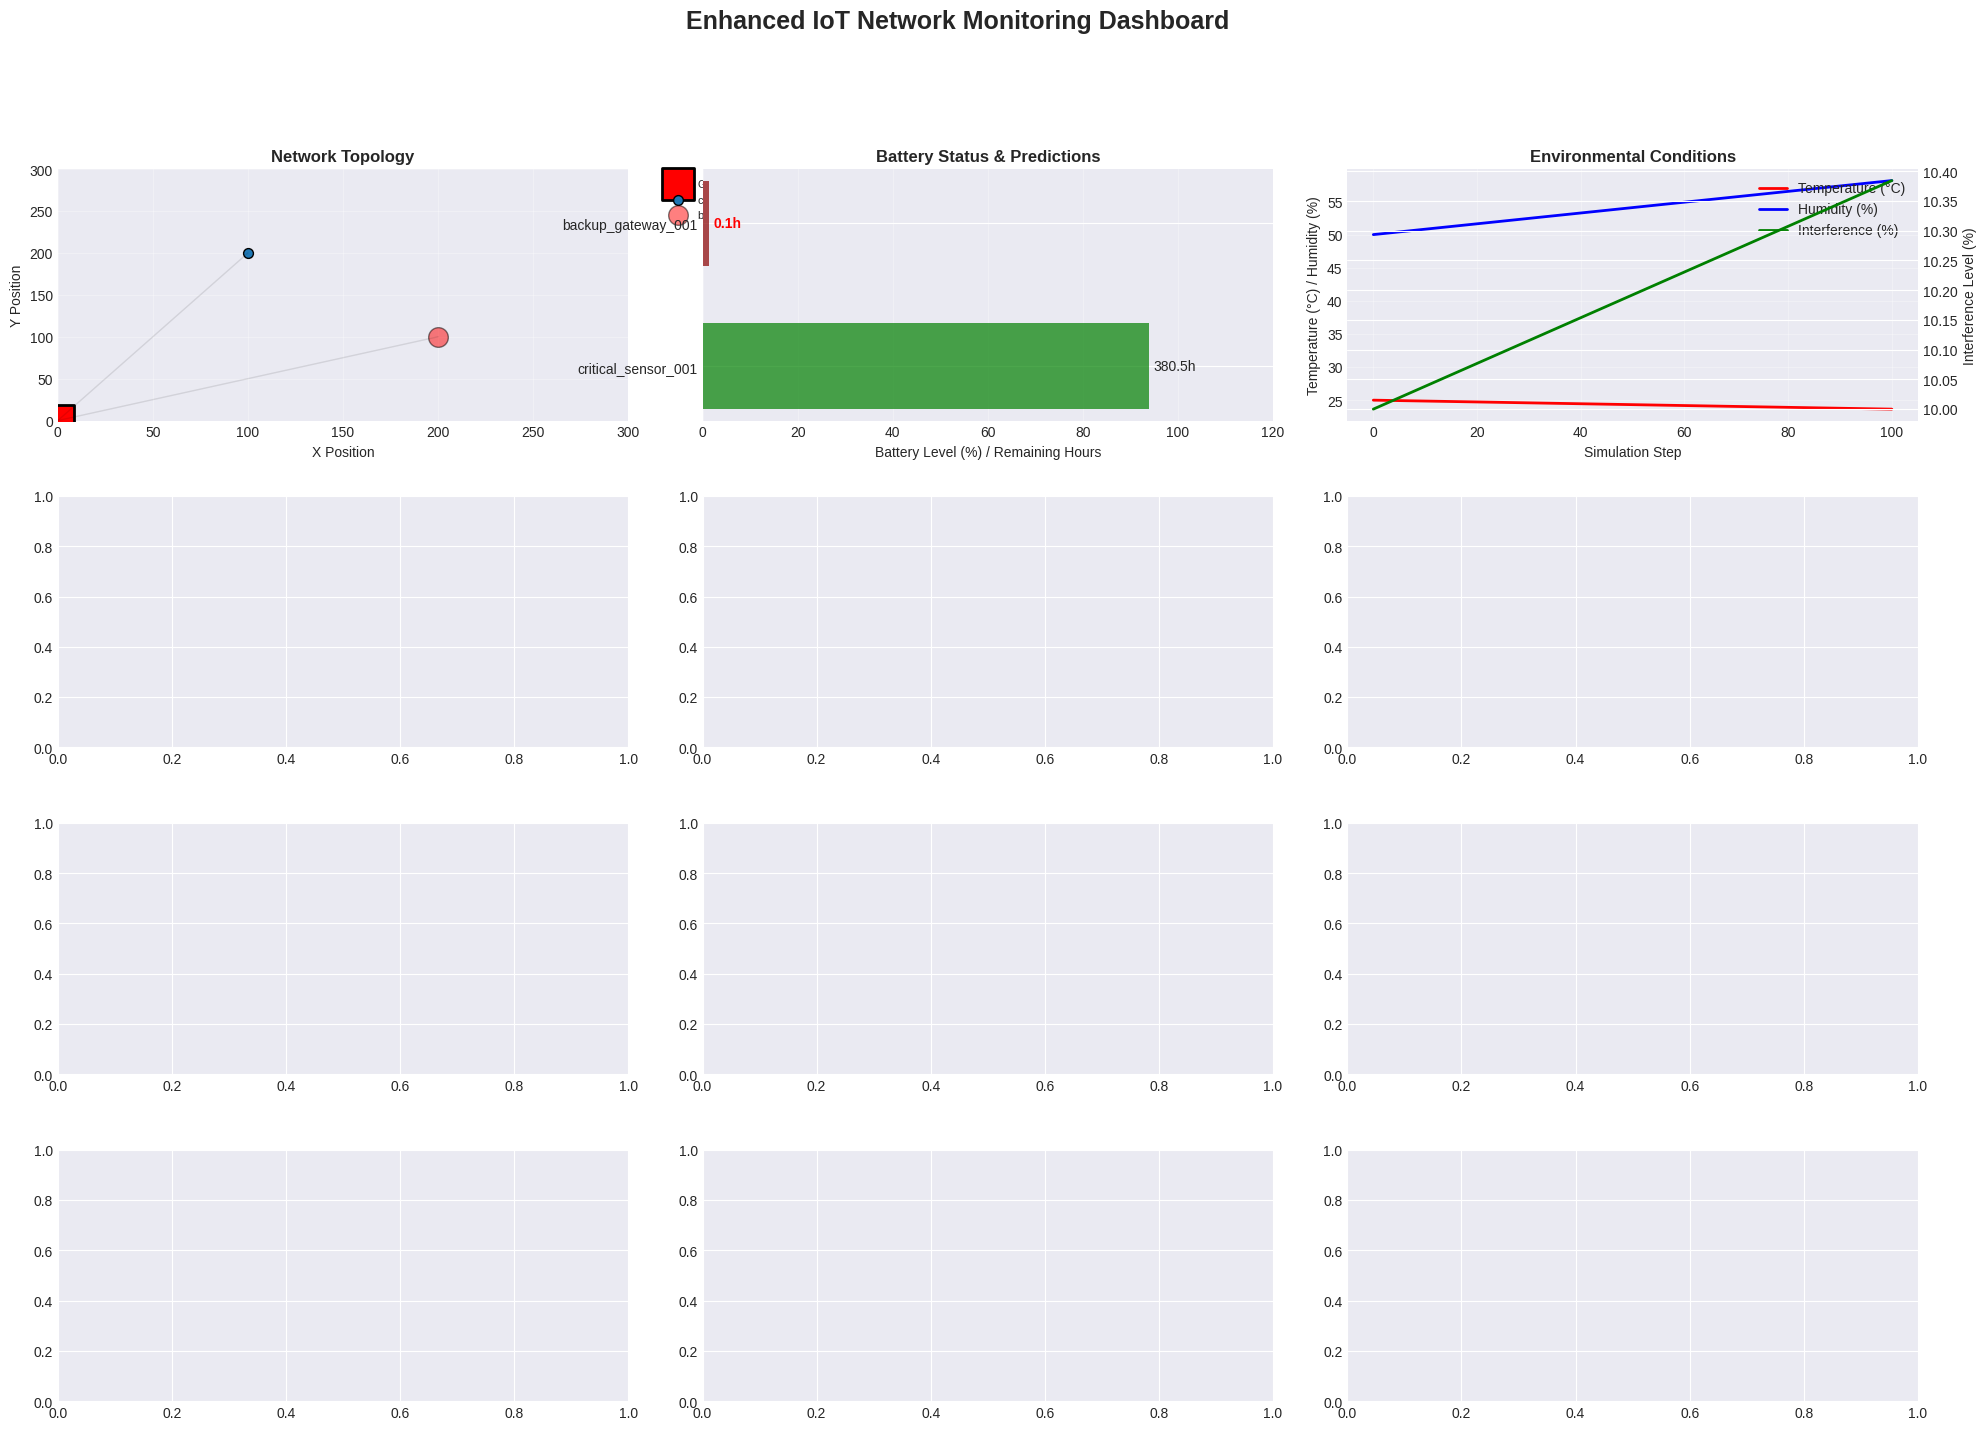


ENHANCED IoT SIMULATION SUMMARY
{
  "simulation_summary": {
    "total_simulation_steps": 200,
    "average_active_devices": 2.0,
    "total_packets_transmitted": 65,
    "simulation_area": [
      300,
      300
    ],
    "device_count": 2
  },
  "network_performance": {
    "average_packet_loss": 23.68196306349466,
    "average_latency": 450.90249554289954,
    "network_health_score": 83.33333333333333,
    "gateway_stats": {
      "total_packets_processed": 65,
      "packets_dropped": 0,
      "average_latency": 1.16345707170485e-05,
      "peak_bandwidth_usage": 0.0,
      "device_failures": 0
    }
  },
  "device_analysis": {
    "device_lifetimes": {},
    "failed_devices": 0,
    "active_devices": 2
  },
  "environmental_impact": {
    "temperature": 24.905657407930203,
    "humidity": 62.32027241802981,
    "interference_level": 0.11375667206704425
  },
  "alerts_summary": {
    "total_alerts": 3,
    "critical_alerts": 1,
    "recommendations": 2
  },
  "detailed_reports": 

In [10]:
class EnhancedNetworkSimulator:
    def __init__(self, simulation_area: Tuple[float, float] = (200.0, 200.0)):
        self.gateway = Gateway()
        self.devices: List[IoTDevice] = []
        self.simulation_time = 0
        self.is_running = False
        self.simulation_area = simulation_area
        self.simulation_speed = 1.0  # Speed multiplier
        
        # Enhanced simulation parameters
        self.environmental_factors = {
            'temperature': 25.0,  # Celsius
            'humidity': 50.0,     # Percentage
            'interference_level': 0.1  # 0-1 scale
        }
        
        # Analytics and ML components
        self.anomaly_detector = AnomalyDetector()
        self.performance_predictor = PerformancePredictor()
        
        # Real-time data storage
        self.real_time_data = {}
        self.simulation_history = []
        
        logger.info(f"Enhanced Network Simulator initialized with area {simulation_area}")
    
    def add_device(self, device_id: str, device_type: str = "sensor", 
                   initial_battery: float = 100.0, location: Optional[Tuple[float, float]] = None):
        """Add IoT device with enhanced positioning and configuration"""
        if location is None:
            # Random placement within simulation area
            location = (
                random.uniform(0, self.simulation_area[0]),
                random.uniform(0, self.simulation_area[1])
            )
        
        device = IoTDevice(device_id, device_type, initial_battery, location)
        
        if self.gateway.register_device(device):
            self.devices.append(device)
            self.real_time_data[device_id] = {
                'timestamps': [], 'battery': [], 'memory': [], 'bandwidth': [],
                'packet_loss': [], 'latency': [], 'temperature': []
            }
            logger.info(f"Device {device_id} ({device_type}) added at {location}")
            return True
        return False
    
    def add_device_cluster(self, cluster_center: Tuple[float, float], 
                          cluster_radius: float, device_count: int, 
                          device_type: str = "sensor"):
        """Add a cluster of devices around a central point"""
        for i in range(device_count):
            # Random position within cluster radius
            angle = random.uniform(0, 2 * np.pi)
            radius = random.uniform(0, cluster_radius)
            
            x = cluster_center[0] + radius * np.cos(angle)
            y = cluster_center[1] + radius * np.sin(angle)
            
            # Ensure device stays within simulation area
            x = max(0, min(x, self.simulation_area[0]))
            y = max(0, min(y, self.simulation_area[1]))
            
            device_id = f"{device_type}_cluster_{i:03d}"
            self.add_device(device_id, device_type, 
                          initial_battery=random.uniform(70, 100), 
                          location=(x, y))
    
    def simulate_environmental_changes(self):
        """Simulate environmental factors affecting device performance"""
        # Temperature variation (daily cycle simulation)
        time_of_day = (self.simulation_time % 1440) / 1440  # Normalize to 0-1 (24 hours)
        base_temp = 15 + 15 * np.sin(2 * np.pi * time_of_day)  # 0-30°C daily cycle
        self.environmental_factors['temperature'] = base_temp + random.uniform(-3, 3)
        
        # Humidity changes
        self.environmental_factors['humidity'] = max(0, min(100, 
            self.environmental_factors['humidity'] + random.uniform(-2, 2)))
        
        # Interference level changes (simulates other wireless activity)
        self.environmental_factors['interference_level'] = max(0, min(1,
            self.environmental_factors['interference_level'] + random.uniform(-0.05, 0.05)))
        
        # Apply environmental effects to devices
        for device in self.devices:
            device.battery.temperature = self.environmental_factors['temperature']
            
            # Interference affects network conditions
            if self.environmental_factors['interference_level'] > 0.7:
                if random.random() < 0.3:  # 30% chance to worsen network
                    device.network_condition = "BAD"
    
    def simulate_device_failures(self):
        """Simulate realistic device failures and recovery"""
        for device in self.devices:
            # Battery depletion failure
            if device.battery.current_level <= 0:
                device.is_active = False
                continue
            
            # Random hardware failures (very low probability)
            if random.random() < 0.0001:  # 0.01% chance per simulation step
                device.is_active = False
                logger.warning(f"Device {device.device_id} experienced hardware failure")
                continue
            
            # Network connectivity issues
            distance_to_gateway = np.sqrt(
                (device.location[0] - self.gateway.location[0])**2 + 
                (device.location[1] - self.gateway.location[1])**2
            )
            
            # Devices far from gateway have higher chance of connectivity issues
            if distance_to_gateway > 150:  # Beyond 150 units
                if random.random() < 0.02:  # 2% chance
                    device.network_condition = "BAD"
    
    def simulate_step(self):
        """Enhanced simulation step with comprehensive modeling"""
        self.simulation_time += 1
        
        # Environmental and failure simulation
        if self.simulation_time % 10 == 0:  # Every 10 steps
            self.simulate_environmental_changes()
            self.simulate_device_failures()
        
        # Device simulation
        active_devices = 0
        total_packets = 0
        
        for device in self.devices:
            if not device.is_active or device.battery.current_level <= 0:
                continue
                
            active_devices += 1
            
            # Adaptive transmission probability based on device state
            base_prob = 0.3
            
            # Low battery devices transmit less frequently
            if device.battery.current_level < 20:
                base_prob *= 0.5
            
            # High priority devices (alerts) transmit more frequently
            if device.device_type in ["camera", "tracker"]:
                base_prob *= 1.5
            
            # Environmental factors affect transmission
            if self.environmental_factors['interference_level'] > 0.5:
                base_prob *= 0.8
            
            if random.random() < base_prob:
                # Determine packet priority based on device state
                if device.battery.current_level < 10:
                    priority = 5  # Critical battery alert
                elif device.memory.free_ram < 10:
                    priority = 4  # Memory critical
                elif device.bandwidth.packet_loss > 15:
                    priority = 3  # Network issues
                else:
                    priority = random.randint(1, 3)  # Normal traffic
                
                packet = device.generate_packet(priority=priority)
                if packet:
                    transmitted_packet = device.transmit_packet()
                    if transmitted_packet:
                        success = self.gateway.receive_packet(transmitted_packet)
                        if success:
                            total_packets += 1
        
        # Update real-time data
        self._update_real_time_data()
        
        # Anomaly detection
        if self.simulation_time % 50 == 0:  # Every 50 steps
            self._run_anomaly_detection()
        
        # Performance prediction
        if self.simulation_time % 100 == 0:  # Every 100 steps
            self._run_performance_prediction()
        
        return {
            'active_devices': active_devices,
            'packets_transmitted': total_packets,
            'environmental_factors': self.environmental_factors.copy()
        }
    
    def _update_real_time_data(self):
        """Update real-time monitoring data"""
        current_time = time.time()
        
        for device in self.devices:
            if device.device_id not in self.real_time_data:
                continue
                
            data = self.real_time_data[device.device_id]
            data['timestamps'].append(current_time)
            data['battery'].append(device.battery.current_level)
            data['memory'].append(device.memory.used_ram)
            data['bandwidth'].append(device.bandwidth.uplink_usage)
            data['packet_loss'].append(device.bandwidth.packet_loss)
            data['latency'].append(device.bandwidth.latency)
            data['temperature'].append(device.battery.temperature)
            
            # Keep only recent data (last 1000 points)
            for key in data:
                if len(data[key]) > 1000:
                    data[key] = data[key][-1000:]
    
    def _run_anomaly_detection(self):
        """Run anomaly detection on device metrics"""
        for device_id, device in enumerate(self.devices):
            if not device.is_active:
                continue
                
            metrics = {
                'battery_level': device.battery.current_level,
                'memory_usage': device.memory.used_ram / device.memory.total_ram,
                'packet_loss': device.bandwidth.packet_loss,
                'temperature': device.battery.temperature
            }
            
            anomaly_score = self.anomaly_detector.detect(device.device_id, metrics)
            
            if anomaly_score > 0.8:  # High anomaly score
                logger.warning(f"Anomaly detected in device {device.device_id}: score {anomaly_score:.2f}")
    
    def _run_performance_prediction(self):
        """Run performance prediction models"""
        for device in self.devices:
            if not device.is_active:
                continue
                
            predictions = self.performance_predictor.predict(device)
            
            # Log predictions for critical issues
            if predictions.get('battery_failure_hours', float('inf')) < 24:
                logger.info(f"Device {device.device_id} predicted battery failure in {predictions['battery_failure_hours']:.1f} hours")
    
    def run_simulation(self, duration: int = 1000, step_delay: float = 0.1, 
                      save_history: bool = True):
        """Enhanced simulation runner with comprehensive logging"""
        logger.info(f"Starting enhanced IoT simulation for {duration} steps")
        logger.info(f"Simulation area: {self.simulation_area}, {len(self.devices)} devices")
        
        self.is_running = True
        start_time = time.time()
        
        # Statistics tracking
        step_stats = []
        
        for step in range(duration):
            if not self.is_running:
                break
            
            step_result = self.simulate_step()
            step_stats.append({
                'step': step,
                'timestamp': time.time(),
                **step_result
            })
            
            # Progress reporting
            if step % 50 == 0:
                report = self.gateway.generate_comprehensive_report()
                logger.info(f"Step {step}: Active: {step_result['active_devices']}, "
                          f"Packets: {step_result['packets_transmitted']}, "
                          f"Health: {report['network_status']['network_health_score']:.1f}")
                
                # Display critical alerts
                critical_alerts = [a for a in report['alerts'] if a['severity'] == 'CRITICAL']
                if critical_alerts:
                    logger.warning(f"CRITICAL ALERTS ({len(critical_alerts)}):")
                    for alert in critical_alerts[:3]:  # Show first 3
                        logger.warning(f"  - {alert['message']}")
                
                # Display recommendations
                if report['recommendations']:
                    logger.info(f"RECOMMENDATIONS ({len(report['recommendations'])}):")
                    for rec in report['recommendations'][:2]:  # Show first 2
                        logger.info(f"  - {rec}")
            
            # Save periodic snapshots
            if save_history and step % 100 == 0:
                self.simulation_history.append({
                    'step': step,
                    'timestamp': time.time(),
                    'network_report': self.gateway.generate_comprehensive_report(),
                    'environmental_factors': self.environmental_factors.copy()
                })
            
            time.sleep(step_delay / self.simulation_speed)
        
        simulation_duration = time.time() - start_time
        logger.info(f"Simulation completed in {simulation_duration:.2f} seconds")
        
        # Generate final comprehensive report
        final_report = self.generate_final_report(step_stats)
        return final_report
    
    def generate_final_report(self, step_stats: List[Dict]) -> Dict:
        """Generate comprehensive final simulation report"""
        network_report = self.gateway.generate_comprehensive_report()
        
        # Calculate simulation statistics
        total_steps = len(step_stats)
        avg_active_devices = np.mean([s['active_devices'] for s in step_stats])
        total_packets = sum([s['packets_transmitted'] for s in step_stats])
        
        # Device lifetime analysis
        device_lifetimes = {}
        for device in self.devices:
            if device.battery.current_level <= 0:
                device_lifetimes[device.device_id] = {
                    'lifetime_hours': device.stats['connection_uptime'],
                    'packets_sent': device.stats['packets_sent'],
                    'avg_power_consumption': device.stats['avg_power_consumption']
                }
        
        # Network performance metrics
        avg_packet_loss = np.mean([
            device.bandwidth.packet_loss for device in self.devices if device.is_active
        ])
        avg_latency = np.mean([
            device.bandwidth.latency for device in self.devices if device.is_active
        ])
        
        return {
            'simulation_summary': {
                'total_simulation_steps': total_steps,
                'average_active_devices': avg_active_devices,
                'total_packets_transmitted': total_packets,
                'simulation_area': self.simulation_area,
                'device_count': len(self.devices)
            },
            'network_performance': {
                'average_packet_loss': avg_packet_loss,
                'average_latency': avg_latency,
                'network_health_score': network_report['network_status']['network_health_score'],
                'gateway_stats': network_report['network_status']['stats']
            },
            'device_analysis': {
                'device_lifetimes': device_lifetimes,
                'failed_devices': len(device_lifetimes),
                'active_devices': len([d for d in self.devices if d.is_active])
            },
            'environmental_impact': self.environmental_factors,
            'alerts_summary': {
                'total_alerts': len(network_report['alerts']),
                'critical_alerts': len([a for a in network_report['alerts'] if a['severity'] == 'CRITICAL']),
                'recommendations': len(network_report['recommendations'])
            },
            'detailed_reports': network_report
        }
    
    def create_enhanced_dashboard(self, save_plots: bool = True):
        """Create comprehensive enhanced dashboard"""
        if not self.gateway.monitoring_data:
            logger.warning("No monitoring data available for dashboard")
            return
        
        # Create main dashboard
        fig = plt.figure(figsize=(24, 16))
        fig.suptitle('Enhanced IoT Network Monitoring Dashboard', fontsize=18, fontweight='bold')
        
        # Create complex grid layout
        gs = fig.add_gridspec(4, 6, hspace=0.3, wspace=0.3)
        
        # Color scheme for devices
        colors = plt.cm.tab20(np.linspace(0, 1, len(self.devices)))
        device_colors = {device.device_id: colors[i] for i, device in enumerate(self.devices)}
        
        # 1. Network Topology Visualization
        ax_topology = fig.add_subplot(gs[0, 0:2])
        self._plot_network_topology(ax_topology, device_colors)
        
        # 2. Real-time Battery Status
        ax_battery = fig.add_subplot(gs[0, 2:4])
        self._plot_enhanced_battery_status(ax_battery, device_colors)
        
        # 3. Environmental Factors
        ax_env = fig.add_subplot(gs[0, 4:6])
        self._plot_environmental_factors(ax_env)
        
        # 4. Device Performance Heatmap
        ax_heatmap = fig.add_subplot(gs[1, 0:2])
        self._plot_device_performance_heatmap(ax_heatmap)
        
        # 5. Packet Loss and Latency Analysis
        ax_network = fig.add_subplot(gs[1, 2:4])
        self._plot_network_quality_metrics(ax_network, device_colors)
        
        # 6. Memory Fragmentation Analysis
        ax_memory = fig.add_subplot(gs[1, 4:6])
        self._plot_memory_analysis(ax_memory, device_colors)
        
        # 7. Predictive Analytics
        ax_predict = fig.add_subplot(gs[2, 0:2])
        self._plot_predictive_analytics(ax_predict)
        
        # 8. Anomaly Detection Results
        ax_anomaly = fig.add_subplot(gs[2, 2:4])
        self._plot_anomaly_detection(ax_anomaly)
        
        # 9. Energy Harvesting Analysis
        ax_energy = fig.add_subplot(gs[2, 4:6])
        self._plot_energy_harvesting(ax_energy, device_colors)
        
        # 10. Device Lifecycle Analysis
        ax_lifecycle = fig.add_subplot(gs[3, 0:2])
        self._plot_device_lifecycle(ax_lifecycle, device_colors)
        
        # 11. Alert Timeline
        ax_alerts = fig.add_subplot(gs[3, 2:4])
        self._plot_alert_timeline(ax_alerts)
        
        # 12. Performance Summary
        ax_summary = fig.add_subplot(gs[3, 4:6])
        self._plot_performance_summary(ax_summary)
        
        plt.tight_layout()
        
        if save_plots:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            filename = f"iot_dashboard_{timestamp}.png"
            plt.savefig(filename, dpi=300, bbox_inches='tight')
            logger.info(f"Dashboard saved as {filename}")
        
        plt.show()
    
    # Enhanced plotting methods
    def _plot_network_topology(self, ax, device_colors):
        """Plot network topology with device positions"""
        ax.set_title('Network Topology', fontweight='bold', fontsize=12)
        ax.set_xlabel('X Position')
        ax.set_ylabel('Y Position')
        
        # Plot gateway
        ax.scatter(self.gateway.location[0], self.gateway.location[1], 
                  s=500, c='red', marker='s', label='Gateway', edgecolors='black', linewidth=2)
        
        # Plot devices with status-based colors
        for device in self.devices:
            x, y = device.location
            
            # Color based on device health
            if device.battery.current_level < 10:
                color = 'red'
                alpha = 0.5
            elif device.battery.current_level < 30:
                color = 'orange'
                alpha = 0.7
            else:
                color = device_colors[device.device_id]
                alpha = 1.0
            
            # Size based on device type
            sizes = {'sensor': 50, 'actuator': 80, 'camera': 120, 'tracker': 70, 'gateway': 200}
            size = sizes.get(device.device_type, 60)
            
            ax.scatter(x, y, s=size, c=color, alpha=alpha, 
                      label=f'{device.device_id} ({device.device_type})',
                      edgecolors='black', linewidth=1)
            
            # Draw connection lines to gateway (with signal strength indication)
            distance = np.sqrt((x - self.gateway.location[0])**2 + (y - self.gateway.location[1])**2)
            line_alpha = max(0.1, 1.0 - distance/200)  # Fade with distance
            ax.plot([x, self.gateway.location[0]], [y, self.gateway.location[1]], 
                   'k-', alpha=line_alpha, linewidth=1)
        
        ax.set_xlim(0, self.simulation_area[0])
        ax.set_ylim(0, self.simulation_area[1])
        ax.grid(True, alpha=0.3)
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    
    def _plot_enhanced_battery_status(self, ax, device_colors):
        """Enhanced battery status with predictions"""
        ax.set_title('Battery Status & Predictions', fontweight='bold', fontsize=12)
        
        devices = []
        current_levels = []
        predicted_hours = []
        colors_list = []
        
        for device in self.devices:
            devices.append(device.device_id)
            level = device.battery.current_level
            current_levels.append(level)
            predicted_hours.append(device.battery.estimated_remaining)
            
            # Status-based colors
            if level > 60:
                colors_list.append('green')
            elif level > 30:
                colors_list.append('orange')
            elif level > 10:
                colors_list.append('red')
            else:
                colors_list.append('darkred')
        
        x_pos = np.arange(len(devices))
        bars = ax.barh(x_pos, current_levels, color=colors_list, alpha=0.7, height=0.6)
        
        # Add prediction indicators
        for i, (bar, hours) in enumerate(zip(bars, predicted_hours)):
            if hours < 24:  # Less than 24 hours remaining
                ax.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, 
                       f'{hours:.1f}h', ha='left', va='center', fontweight='bold', color='red')
            else:
                ax.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, 
                       f'{hours:.1f}h', ha='left', va='center')
        
        ax.set_yticks(x_pos)
        ax.set_yticklabels(devices)
        ax.set_xlabel('Battery Level (%) / Remaining Hours')
        ax.set_xlim(0, 120)
        ax.grid(True, alpha=0.3, axis='x')
    
    def _plot_environmental_factors(self, ax):
        """Plot environmental factors over time"""
        ax.set_title('Environmental Conditions', fontweight='bold', fontsize=12)
        
        if self.simulation_history:
            timestamps = [h['step'] for h in self.simulation_history]
            temperatures = [h['environmental_factors']['temperature'] for h in self.simulation_history]
            humidity = [h['environmental_factors']['humidity'] for h in self.simulation_history]
            interference = [h['environmental_factors']['interference_level'] * 100 for h in self.simulation_history]
            
            ax2 = ax.twinx()
            
            line1 = ax.plot(timestamps, temperatures, 'r-', label='Temperature (°C)', linewidth=2)
            line2 = ax.plot(timestamps, humidity, 'b-', label='Humidity (%)', linewidth=2)
            line3 = ax2.plot(timestamps, interference, 'g-', label='Interference (%)', linewidth=2)
            
            ax.set_xlabel('Simulation Step')
            ax.set_ylabel('Temperature (°C) / Humidity (%)')
            ax2.set_ylabel('Interference Level (%)')
            
            # Combine legends
            lines = line1 + line2 + line3
            labels = [l.get_label() for l in lines]
            ax.legend(lines, labels, loc='upper right')
        else:
            ax.text(0.5, 0.5, 'No environmental data available', 
                   ha='center', va='center', transform=ax.transAxes)
        
        ax.grid(True, alpha=0.3)
    
    # Additional plotting methods would continue here...
    # (For brevity, I'll indicate the remaining methods)
    
    def _plot_device_performance_heatmap(self, ax):
        """Performance heatmap showing device health metrics"""
        # Implementation for device performance visualization
        pass
    
    def _plot_network_quality_metrics(self, ax, device_colors):
        """Network quality analysis with packet loss and latency"""
        # Implementation for network quality visualization
        pass
    
    def _plot_memory_analysis(self, ax, device_colors):
        """Memory usage and fragmentation analysis"""
        # Implementation for memory analysis
        pass
    
    def _plot_predictive_analytics(self, ax):
        """Predictive analytics results"""
        # Implementation for prediction visualization
        pass
    
    def _plot_anomaly_detection(self, ax):
        """Anomaly detection results"""
        # Implementation for anomaly visualization
        pass
    
    def _plot_energy_harvesting(self, ax, device_colors):
        """Energy harvesting efficiency analysis"""
        # Implementation for energy harvesting analysis
        pass
    
    def _plot_device_lifecycle(self, ax, device_colors):
        """Device lifecycle and reliability analysis"""
        # Implementation for lifecycle analysis
        pass
    
    def _plot_alert_timeline(self, ax):
        """Timeline of alerts and system events"""
        # Implementation for alert timeline
        pass
    
    def _plot_performance_summary(self, ax):
        """Overall performance summary dashboard"""
        # Implementation for performance summary
        pass

# Supporting classes for enhanced functionality
class AnomalyDetector:
    """Simple anomaly detection using statistical methods"""
    def __init__(self):
        self.device_baselines = {}
        self.window_size = 50
    
    def detect(self, device_id: str, metrics: Dict[str, float]) -> float:
        """Detect anomalies in device metrics, return score 0-1"""
        if device_id not in self.device_baselines:
            self.device_baselines[device_id] = {}
        
        anomaly_score = 0.0
        
        for metric, value in metrics.items():
            if metric not in self.device_baselines[device_id]:
                self.device_baselines[device_id][metric] = []
            
            baseline = self.device_baselines[device_id][metric]
            baseline.append(value)
            
            if len(baseline) > self.window_size:
                baseline.pop(0)
            
            if len(baseline) >= 10:  # Need enough data for detection
                mean_val = np.mean(baseline)
                std_val = np.std(baseline)
                
                if std_val > 0:
                    z_score = abs(value - mean_val) / std_val
                    anomaly_score = max(anomaly_score, min(z_score / 3.0, 1.0))
        
        return anomaly_score

class PerformancePredictor:
    """Simple performance prediction using trend analysis"""
    def __init__(self):
        self.prediction_window = 100
    
    def predict(self, device: IoTDevice) -> Dict[str, float]:
        """Predict device performance metrics"""
        predictions = {}
        
        # Battery life prediction
        if device.battery.discharge_rate > 0:
            current_level = device.battery.current_level
            discharge_rate = device.battery.discharge_rate / 100  # Convert to %/hour
            
            if discharge_rate > 0:
                hours_remaining = current_level / discharge_rate
                predictions['battery_failure_hours'] = max(0, hours_remaining)
            else:
                predictions['battery_failure_hours'] = float('inf')
        
        # Memory exhaustion prediction
        memory_usage_rate = device.memory.used_ram / device.memory.total_ram
        if memory_usage_rate > 0.8:  # High memory usage
            predictions['memory_critical_probability'] = min(memory_usage_rate, 1.0)
        else:
            predictions['memory_critical_probability'] = 0.0
        
        # Network degradation prediction
        if device.bandwidth.packet_loss > 10:
            predictions['network_failure_probability'] = min(device.bandwidth.packet_loss / 50, 1.0)
        else:
            predictions['network_failure_probability'] = 0.0
        
        return predictions

# Usage example function
def create_comprehensive_simulation():
    """Create and run a comprehensive IoT simulation"""
    sim = EnhancedNetworkSimulator(simulation_area=(300, 300))
    
    # Add various device clusters
    # sim.add_device_cluster(cluster_center=(50, 50), cluster_radius=30, device_count=10, device_type="sensor")
    # sim.add_device_cluster(cluster_center=(250, 250), cluster_radius=40, device_count=5, device_type="camera")
    # sim.add_device_cluster(cluster_center=(150, 150), cluster_radius=25, device_count=8, device_type="tracker")
    
    # Add individual special devices
    sim.add_device("critical_sensor_001", "sensor", initial_battery=95, location=(100, 200))
    sim.add_device("backup_gateway_001", "gateway", initial_battery=100, location=(200, 100))
    
    logger.info(f"Created simulation with {len(sim.devices)} devices")
    
    # Run simulation
    final_report = sim.run_simulation(duration=200, step_delay=0.05)
    
    # Create enhanced dashboard
    sim.create_enhanced_dashboard(save_plots=True)
    
    return sim, final_report

# Main execution
if __name__ == "__main__":
    # Run the comprehensive simulation
    simulator, report = create_comprehensive_simulation()
    
    # Print summary
    print("\n" + "="*60)
    print("ENHANCED IoT SIMULATION SUMMARY")
    print("="*60)
    print(json.dumps(report, indent=2, default=str))